This code has been prouced as a teaching resource for the UKSA space software, data and AI course run by the Space South Central Universities.

Contributors to this code includes: O. Umeh; B. Canning

### Learning Outcome
<div class="alert alert-block alert-info"> 
<b>NOTE</b> In this notebook we will learn how to access open street map data with the osmnx package.
</div>

<div class="alert alert-block alert-warning">
This code demos PART 1 of our deep learning project example.
</div>

As per usual we will import some things we might need.

In [4]:
# os to help us find and use our files on our operating system
import os

# Numpy for maths
import numpy as np

# Some plotting stuff
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# For open street map we are using osmnx, there are other options as well
import osmnx as ox

# To save the data in geojson format we will use this one
import geojson

# Our friend Geopandas for spatial data manipulations
import geopandas as gpd

# And another friend for API requests
import requests

We are picking a 'use case' for our code - in this case we will be interested in identifying buildings pre- and post- earthquake.

There was a 6.8 magnitude earthquake that struck the Atlas Mountains, about 75 km from Marrakech, Morocco on 8 September, 2023

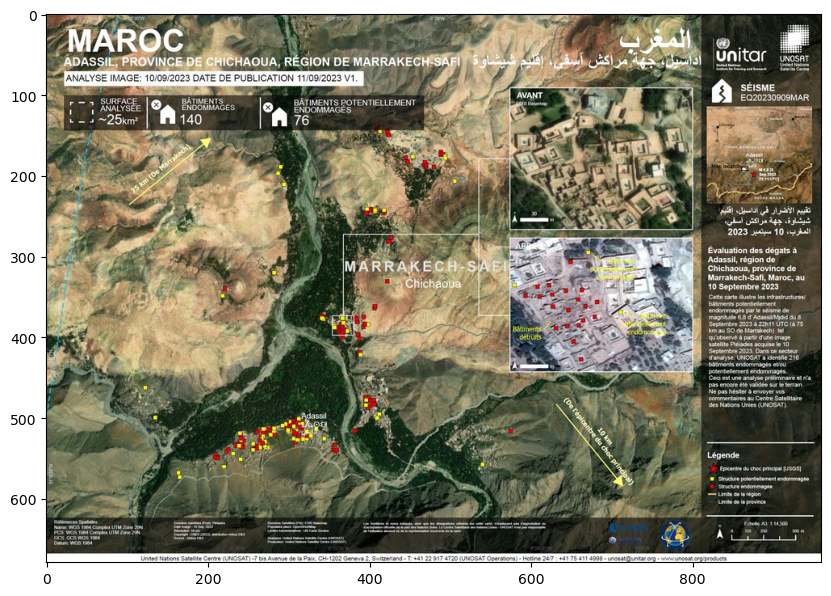

In [5]:
fig, ax = plt.subplots(1, 1,figsize=(10, 10))
ax.imshow(Image.open("Morocco_earthquake_damage_assessment_map_from_the_UNOSAT_team_article.jpg"))

This sort of code could be useful for taking some key actions following an earthquake, such as:

 * Safety and Assessment: Evaluate the stability of buildings and infrastructure.
 * Allocate resources: Direct assiatnce to areas that are impacted the most.

**Our overall aim will be** to create a dataset using open street map (OSM) polygons to annotate buildings in sentineal-2 imagery. Then we will use the dataset to train an object detector (ML/AI) to detect buildings in an unmapped location.

We will need to deploy steps we have learned in our course are more:

* **NOTE** Think about the data we need and its features (research, consult with a GIS domain expert, consult with a disaster and risk expert etc - these are areas your friendly neiboughood academic can help with)
* **NOTE** Think about how to approach the code and directory structures for your use case, and how and if you want generality in your application, how will you version your software appropriately and ensure that it is not 'broken' by underlying software changes, is it affordable to continue to support software updates or do you need a static solution (research, consult with a computational expert - these are areas your friendly neiboughood academic can help with)
* **NOTE** Do you have other factors in deployment you need to consider e.g. cyber security, is speed of the upmost importance, is accuracy of the upmost importance, is computational power of the upmost importance, will you deploy on the edge, are there ethical considerations to either the data, the algorithm or the deployment, will you have liability? (more areas your friendly neiboughood academic can help with)
  
1. Download data of interest (remember the request package examples..)
2. Save data in a format we want (remember the os and glob package examples..)
3. Read in data of interest (remember the rasterio and glob package examples..)
4. Combine spatial data to create building masks on the same coordinate reference system (remember the geopandas package examples..)
5. Augment the data for generality (multiple ways to do this, can write you own code easily enough but remember that the packages like PyTorch Tensorflow etc. also come with fairly quick, speed optimised solutions...)
6. Write a model or load a pre-trained one (remember how to define your models and all your params and hyperparams which can be tweaked...). Benchmark your models with known datasets. 
7. Train (remember again all the steps here which can be tweaked and optimised...) Benchmark your models with known datasets.
8. Visulise results (how will you know when your metric of 'good enough for my application' has been reached? Remember the key visulation steps...)
9. Test and deploy model (consider again robustness, generailty, cyber security, ethics, speed, power requirements to deply, can it be deployed on all platforms needed, will your model need updating over time?)

#### Now let's start our little project...

We'll define and area of interest.

This time we'll do so with a place name - remember we have lots of examples of doign so with bounding boxes, point coordinates etc. 

In [6]:
place_name = "Marrakech, Morocco"
area_of_interest = ox.geocode_to_gdf(place_name)

Now we will use OSM to find that place name and to return us a list of tagged 'buildings'

In [7]:
buildings = ox.features_from_place(place_name, tags={"building": True})

We have already learned we should make test plots for **EVERYTHING** for cheacking purposes and to efficiently debug our code. So let's plot the bounding box of this place name and the buildings.

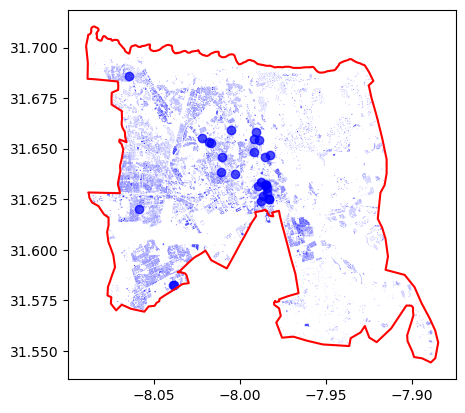

In [8]:
fig, ax = plt.subplots()
area_of_interest.boundary.plot(ax=ax, color="red")
buildings.plot(ax=ax, color="blue", alpha=0.7)
plt.show()

In [13]:
# At this stage we might want to save the building footprints for further use uncomment below to do this
# buildings.to_file("marrakech_buildings.geojson", driver="GeoJSON")

Let's explore the properties of this 'buildings' geodataframe

In [10]:
#Check the total number of buildings from osm
buildings=buildings[['geometry']]
print('the number of buildings are: ',len(buildings))

the number of buildings are:  78162


Now just a little bit of jargon whch might be useful to us as we research into things like this...

**Node:** A node represents a single point on the Earth's surface.

**Way:** A way is a sequence of connected nodes that represents a linear feature, such as a road, river, or trail

**Relations** define complex relationships between nodes and ways, representing larger features or areas


In [12]:
# let's take a look at the geodataframe...
buildings

geometry
element id                                                           
node    1245935291                           POINT (-7.98776 31.6241)
        2620316382                            POINT (-7.984 31.62819)
        3186302961                          POINT (-8.00504 31.65929)
        3204883229                          POINT (-8.01689 31.65265)
        3211517814                          POINT (-7.99084 31.65822)
...                                                               ...
way     1349202716  POLYGON ((-7.97971 31.6267, -7.97972 31.62671,...
        1349202717  POLYGON ((-7.97983 31.62665, -7.97971 31.6267,...
        1349808882  POLYGON ((-7.99541 31.62473, -7.99537 31.62466...
        1352713662  POLYGON ((-7.99535 31.63388, -7.99533 31.63382...
        1352713663  POLYGON ((-7.99625 31.63344, -7.99619 31.63348...

[78162 rows x 1 columns]

<div class="alert alert-block alert-success"> 
 <strong>Exercises</strong>
 <br>
 <li> Explore this data frame. Look back at the geopandas examples notebook to help you - whatr data in avlible here, plot it and look at features of the data - what happens if you plot 'nodes' or plot 'ways'? </li>
 <li> What other data can you use from OSM?  (google them, ask a langauge model, read the help pages, pull in the full dataframe without 'tags' and explore it yourself.)</li>
</div>